<h1> ML Methods for Financial Product Prediction </h1>
<h3> <emph> Project by: System Breakers </emph> </h3>
<h4> Yumeng Du, Yi Gong, Allen (Yi Xin) Hu, Jielin (Katherine) Mao, Zhiyuan Ren </h4>

Having the suitable financial products is critical for consumer's financial well-being, as well as profit generation for banks around the world. In this project, we use a real-world dataset provided by Santander (Spanish bank) to predict whether or not an individual will likely open-up a new credit card account with the bank. 

The following notebook will be split into 2 main sections.

1. Data Processing
2. ML Prediction
3. Results and Discussion

In [14]:
%matplotlib inline
#data importing related packages
import zipfile
import pandas as pd
import numpy as np

#visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

#data processing ml packages
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

#ml packages
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

#model evaluation packages
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

<h2> Data/Feature Processing </h2>

The main challenges of this part of our project is 3 fold:
1. Unbalanced response variable (25:1 unbalance ratio)
2. Primarily binary explainatory variables (do not have enough continuity)
3. General issues with missing values 
4. Large sum of data, cannot be run cheaply on a local machine

To address these issues, we will conduct the following apprach:

1. To simultaniously deal with issue 1) and 4), we decide to downsample the data by randomly selecting the same amount of rows from the majority class to match the amount of rows in the minority class. We find that downsampling does not reduce the data efficiency as the inherent size of the data is very large
3. To deal with issue 2), we conduct PCA pre-analysis to reintroduce continuity into the data and significantly reduce the amount of binary columns that we have to deal with. This drastically increases our model's accuracy as well as decrease the cost of running the model itself
4. To deal with issue 3), we use a simple imputation method deal with missing values. While removing NA values would also be valid due to the large data size, the non-systematic presense of NA values will force us to cut down a surprising amount of our data, therefore we opted for imputation rather than removal.

In [2]:
#loading the data into the notebook
zf = zipfile.ZipFile('update_dataset.zip')
df_train_raw = pd.read_csv(zf.open('train0328_update.csv'),low_memory=False)
#zf = zipfile.ZipFile('test0428.csv.zip')
df_test_raw = pd.read_csv(zf.open('test0428_update.csv'),low_memory=False)

df_train_raw.set_index('cust_code',inplace=True)
df_test_raw.set_index('cust_code',inplace=True)

#Note: even taking 5% of our tesing data,
# we are still able to get over 45,000 rows 
df_train = df_train_raw.sample(frac=1)
df_test = df_test_raw.sample(frac=0.05)

#assertion for sanity check
assert df_train.shape[1] == df_test.shape[1]

<h3> Downsampling the data </h3>

In this step, we define a function which allows us to balance out our response variable (or class/label variable) by downsampling our majority class to the same size as our minority class. This has no data size related issues as our dataset is large.

In [3]:
def downsampling(df,class_,keys=None):
    """
    returns a dataframe that is downsampled
    and with nas removed
    """
    
    class_1_df = df[df[class_]==1] 
    class_0_df = df[df[class_]==0]
    
    #print(class_0_df[class_].shape)
    #print(class_1_df[class_].shape)
    
    n_class_1 = class_1_df.shape[0]
    n_class_0 = class_0_df.shape[0]
    n_samples = min(n_class_1,n_class_0) #get the smaller class as the base class
        
    from sklearn.utils import resample
    if n_class_0 <= n_class_1:
        downsample = resample(class_1_df,
                                replace=False,
                                n_samples=n_class_0,
                                random_state=42)
        ret_df = pd.concat([class_0_df,downsample],keys=keys)
            
    else:
        downsample = resample(class_0_df,
                                replace=False,
                                n_samples=n_class_1,
                                random_state=42)
        ret_df = pd.concat([downsample,class_1_df],keys=keys)
        
    return ret_df.reset_index().drop(columns='level_0')

In [4]:
#downsampling the training set
df_train_ds = downsampling(df_train,'new_credit_card',['no_cc','cc']).set_index('cust_code')

#sanity check for inconsistencies in downsamplings
assert df_train_ds.shape[1] == df_test.shape[1]
assert set(df_train_ds.columns) - set(df_test.columns) == set()

<h3> Now we move on to creating our tuning (aka 'full_train') and validation (aka 'final_test) dataframes. </h3>

Furthermore, we are removing all rows in the testing data where their credit card information is missing

In [54]:
dropping = ['new_credit_card','credit_card','next_credit_card','Unnamed: 0','prov_code']
df_test_filtered = df_test[df_test.loc[:,'new_credit_card']<2]

#remove columns where we have low varaince

full_train_Xs = df_train_ds.drop(columns=dropping)
full_train_y = df_train_ds.loc[:,'new_credit_card']

final_test_Xs = df_test_filtered.drop(columns=dropping)
final_test_y = df_test_filtered.loc[:,'new_credit_card']

#sanity check for dataframe reshaping
assert full_train_Xs.shape[1] == final_test_Xs.shape[1]
assert final_test_y.shape[0] == final_test_Xs.shape[0]
assert full_train_y.shape[0] == full_train_Xs.shape[0]

<h3> Imputation/OHE pipeline </h3>

In this step, we define a preprocessing pipeline to deal with missing values as well as one-hot encode our categorical variables. We find that once the one-hot encoding is conducted, our dataframe size explodes. This combined with a unhealthy amount of binary columns naturally lends itself to PCA, which follows this step.

In [55]:
obj_Xs

['fetch_date',
 'emp_index',
 'country',
 'sex',
 'cust_date',
 'new_cust',
 'indrel',
 'last_date_as_primary',
 'cust_type',
 'cust_rel',
 'residence_index',
 'foreigner_index',
 'joining_channel',
 'deceased',
 'prov_name',
 'activity_index',
 'segmentation',
 'savings_account',
 'guarantees',
 'current_account',
 'derivative_account',
 'payroll_account',
 'junior_account',
 'mas_account',
 'perticular_account',
 'perticular_plus',
 'st_deposit',
 'mt_deposits',
 'lt_deposits',
 'e_account',
 'funds',
 'mortgage',
 'pension',
 'loan',
 'tax',
 'securities',
 'home_account',
 'payroll',
 'pension2',
 'direct_debit',
 'credit_card_cumlen',
 'l_cc',
 'll_cc',
 'cc_close_lastmon',
 'credit_card_close']

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer 


obj_Xs = full_train_Xs.drop(columns=['age','cust_seniority','income']).columns.tolist()
num_Xs = ['age','cust_seniority','income']

categorical_pipe = Pipeline(steps=[
        ('one_hot', OneHotEncoder(handle_unknown='ignore',sparse=False,dtype='int')),
        ('KNNimpute', KNNImputer()),
        ('pca',PCA(.95))
    ])

numeric_pipe = Pipeline(steps=[
        ('impute mean', SimpleImputer(strategy='mean')),
        ('scale', MinMaxScaler()),
        ('variance_cutoff',VarianceThreshold(0))
    ])

preprocessor = ColumnTransformer(transformers=[
        ('categorical',categorical_pipe,obj_Xs),
        ('numerical',numeric_pipe,num_Xs),
    ])

<h3> and now we move ahead with train-test splitting to train our model </h3>

In [58]:
from sklearn.model_selection import train_test_split
train_Xs, test_Xs, train_y, test_y = train_test_split(full_train_Xs,
                                                      full_train_y,
                                                      test_size=0.4,
                                                      random_state=42,
                                                      stratify=full_train_y)

Please note that fit_transform and transform are completely different, as we only fit_transform our training data, but we must only transform or test and validation (final_test_Xs),

<h2> Model and Pipeline Implementation </h2>

In this step, we will use leverage our predefined pipelines and datasets to run a few different models and check their performance with various measures.

<h4> Logistic (Penalized) Regression </h4>

The reason why we decided to use logsitic regression is simple: 
1. The sigmoid function condenses an $R^+$ variable into something between $[0,1]$, which gives us an intutitve measure of the probability that we would assign 1 to our row or 0.
2. Penalization is due to the fact that once we have one-hot encoded many categorical variables, we will have a very sparse feature set. In order to give a robust prediction, L1 penalization will be used to *'kill off'* coefficients that are essencially noise.

In [59]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = 'saga',penalty='l1') #defining our model

logit_pipe = Pipeline(steps=[ # defining our pipeline
    ('preprocessing',preprocessor),
    ('logit',logisticRegr)
])

logit_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(dtype='int',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('KNNimpute',
                                                                   KNNImputer()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95))]),
                                                  ['fetch_date', 'emp_index',
                                                   'country', 'sex',
                                                   'cust_date', 'new_cust',
                                                   'indrel',
                                                   'last_date_as_primary',
                                                   'cust_type', 'cust_rel...
                                                   'junior_account',
                                                   'mas_account',
                                                   'perticular_account',
                                                   'perticular_plus',
                                                   'st_deposit', 'mt_deposits',
                                                   'lt_deposits', 'e_account', ...]),
                                                 ('numerical',
                                                  Pipeline(steps=[('impute '
                                                                   'mean',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler()),
                                                                  ('variance_cutoff',
                                                                   VarianceThreshold(threshold=0))]),
                                                  ['age', 'cust_seniority',
                                                   'income'])])),
                ('logit', LogisticRegression(penalty='l1', solver='saga'))])

Above is our full feature engineering process and how that feeds into our model. Notice in particular that we are processing numerical and categorical variables differently, as they demand special attention. See *Feature Engineering* for more

In [62]:
#defining helper functions 

def get_tpr_fpr_graph(proba,true):
    tprs = []
    fprs = []
    
    fig, ax = plt.subplots()

    for i in np.linspace(0, 1, num=20):
        preds_binary = np.where(proba<i,0,1)
        tn,fp,fn,tp = confusion_matrix(true,preds_binary).ravel()
        tprs.append(tp/(tp+fn))
        fprs.append(fp/(fp+tn))

    plt.plot(tprs, label='True Positive Rate')
    plt.plot(fprs, label='False Positive Rate')
    ax.set_xticklabels(np.arange(-0.125, 1.125, 0.125))
    plt.legend(title='Group')
    plt.show()
    
def get_binaries(train_y,test_y):
    from sklearn.preprocessing import LabelBinarizer
    
    label_binarizer = LabelBinarizer().fit(train_y)
    y_onehot_test = label_binarizer.transform(test_y)
    (y_onehot_test.shape) # (n_samples, n_classes)
    
    class_of_interest = "new_credit_card"
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)
    print(class_id)

def get_confusion_mtx(df):
    y_actu = df.loc[:,'true values']
    y_pred = df.loc[:,'predicted values']
    
    return confusion_matrix(y_actu,y_pred)

def graph_preds(validation,prediction,model_name='Model'):
    y_valid_ser = pd.Series(validation.reshape(1,-1)[0]).rename('true values')
    compare_df = pd.DataFrame(pd.Series(prediction).rename('predicted values')).join(y_valid_ser)
    
    confusion_mtx = get_confusion_mtx(compare_df)
    confusion_mtx = np.around(confusion_mtx/compare_df.shape[0],4)*100
    
    
    #adding jitters to the dataframe
    rows = compare_df.shape[0]
    compare_df = compare_df.apply(lambda x: x+np.random.randn(rows)*0.05)
    
    
    compare_df.plot.scatter(x='predicted values',
                            y='true values',
                            s=0.2)
    
    plt.xlim((-0.5,1.5))
    plt.ylim((-0.5,1.5))
    plt.xticks(range(0,2))
    plt.yticks(range(0,2))
    
    plt.text(0-0.3,1.3,f'False Negatives: {round(confusion_mtx[1,0],2)}%')#pred,actual
    plt.text(0-0.3,0.3,f'True Negatives: {round(confusion_mtx[0,0],2)}%')
    plt.text(1-0.3,0.3,f'False Positives: {round(confusion_mtx[0,1],2)}%')
    plt.text(1-0.3,1.3,f'True Positives: {round(confusion_mtx[1,1],2)}%')
    
    #plt.plot([-2,2],[-2,2],c='red',ls='--')
    plt.plot([0.5,0.5],[-0.5,1.5],c='black')
    plt.plot([-0.5,1.5],[0.5,0.5],c='black')
    
    plt.title(f'Scatterplot Representation of {model_name} Confusion Matrix')
    
def get_roc(test_y,preds_proba,model_name='Model'):
    import matplotlib.pyplot as plt
    from sklearn.metrics import RocCurveDisplay as roc_display
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc

    fpr, tpr, thresholds = roc_curve(test_y,preds_proba)
    roc_auc = auc(fpr,tpr)
    display = roc_display(fpr=fpr,tpr=tpr,roc_auc=roc_auc,
                          estimator_name=f'{model_name}')
    
    plt.title(f'ROC Curve for the {model_name}')
    display.plot()
    plt.show()
    
def model_output(model, x_test, y_test, threshold, model_name):
    
    preds = model.predict_proba(x_test)[:,1]
    get_tpr_fpr_graph(preds,y_test)
    
    preds_binary = np.where(preds>threshold,1,0)
    graph_preds(preds_binary,np.array(y_test), model_name)
    get_roc(y_test,preds)
    plt.show()

In [66]:
# Fitting the Logit Pipe
fitted_logit = logit_pipe.fit(train_Xs,train_y)

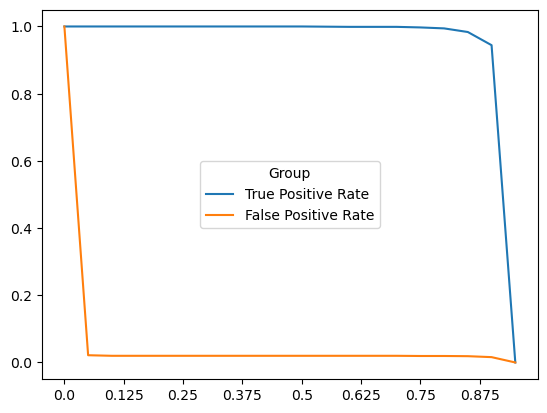

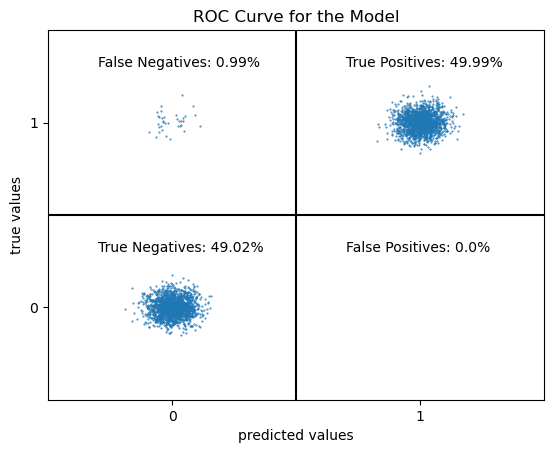

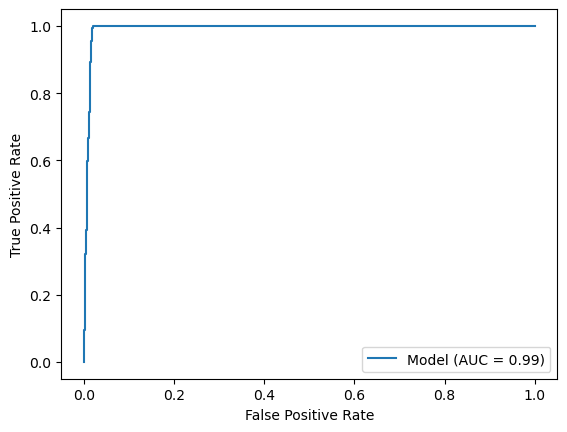

In [64]:
model_output(fitted_logit,test_Xs,test_y,0.2,'Penalized Logit')

This result is eerily outstanding (with a cut-off at 0.5), which begs the question if we are overfitting or not.

To see if this is true, we now use the fitted logit model to predict out of sample

<h5> Testing Our Model Out of Sample </h5>

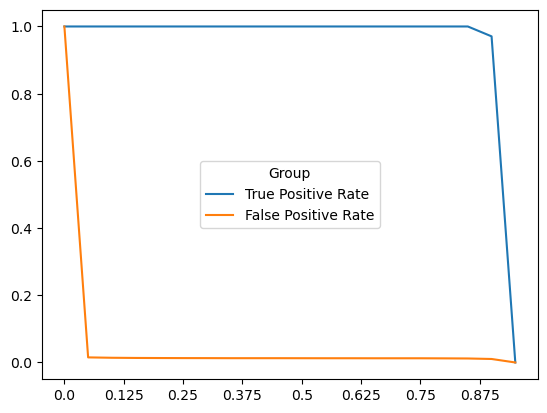

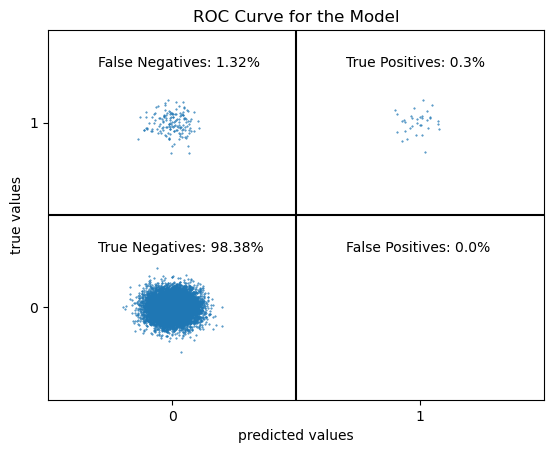

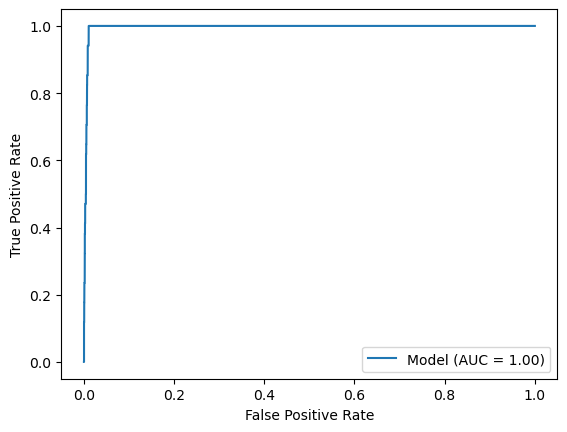

In [65]:
model_output(fitted_logit,final_test_Xs,final_test_y,0.2,'Penalized Logit')

Using our fitted penalized logit model, we are able to get an outstanding score out of sample. That is, our model was able to correctly identify most of the true negatives, and also not over-commit and *only predict negatives* but also correctly responded to positives as well. This came at a cost of having some false negatives. But as discussed in the write-up, the **business value** of getting a true positive far outweighs a false negative. That is to say, the advertising costs of one addtional customer for credit cards completely outweighted by the business gain of having a credit card user at Santander. Therefore. This penalized logit model preforms extraordinarily well.

<h4> Random Forest Classifier </h4>

<h4> XGBoost </h4>